<a href="https://colab.research.google.com/github/A-Raafat/Pneumothorax-Segmenation-kaggle-competition/blob/master/Pneumothorax_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from getpass import getpass
import os
user = 'aahbe2007'
key = '693b3d81b85651351be36a4b919b31db'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!pip3 install --upgrade --force-reinstall kaggle

In [3]:
!kaggle datasets download -d abhishek/siim-dicom-images

100% 1.51G/1.52G [00:36<00:00, 44.5MB/s]
100% 1.52G/1.52G [00:36<00:00, 44.7MB/s]


In [0]:
!unzip siim-dicom-images.zip

In [0]:
!pip install pydicom

In [0]:
import matplotlib.pyplot as plt
import pydicom, numpy as np
import pandas as pd
import os
import random
import cv2


train_dir = 'siim-original/dicom-images-train/'

In [7]:
filenames = os.listdir(train_dir)
size = len(filenames)
n_batches = size//32

n_valid = (n_batches - n_batches%100)/10
n_train = int((n_batches - n_valid)*32)
n_valid = int(n_valid * 32)


train_filenames = filenames[n_valid : n_train + n_valid]
valid_filenames = filenames[:n_valid]

print('Training samples = ', size )
print('Total number of batches = ', n_batches)
print('Number of training examples =', len(train_filenames))
print('Number of validation examples =', len(valid_filenames))
print('Total samples taken = ', n_valid + n_train)

Training samples =  10712
Total number of batches =  334
Number of training examples = 9728
Number of validation examples = 960
Total samples taken =  10688


In [8]:
def get_dcm(x, TD):
  y = os.listdir(TD + x )[0]
  x = x + '/' + y 
  dcm = os.listdir(TD + x)[0]
  full_path = TD  + x + '/' + dcm
  return  full_path, dcm.split('.dcm')[0]


get_dcm(train_filenames[0], train_dir)

('siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1642.1517875168.705406/1.2.276.0.7230010.3.1.3.8323329.1642.1517875168.705405/1.2.276.0.7230010.3.1.4.8323329.1642.1517875168.705407.dcm',
 '1.2.276.0.7230010.3.1.4.8323329.1642.1517875168.705407')

In [0]:
patientId, _ = get_dcm(train_filenames[0], train_dir)

img = pydicom.dcmread(patientId).pixel_array

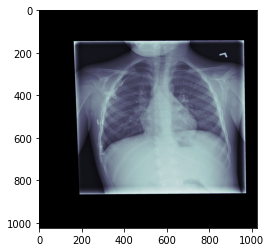

In [10]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap= plt.cm.bone)

In [11]:
img.shape

(1024, 1024)

In [12]:
df = pd.read_csv('train-rle.csv')
df.head()

ImageId                                      EncodedPixels
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...                                                 -1
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...                                                 -1
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

In [0]:
def process_labels(labels):
  a = []
  for i in labels:
    if i == ' -1':
      a.append(0)
    else: a.append(1)
  return np.array(a, dtype='uint8')

In [0]:
labels = df[" EncodedPixels"].to_list()
labels = process_labels(labels)

x=df['ImageId'].values
data = { 'ImageId' : x,
        ' EncodedPixels' : labels}
DATA = pd.DataFrame(data , columns= ["ImageId", ' EncodedPixels'])

In [0]:
def generator(filenames, TD, df, batch_size=32):

  while True:

    sample_fn = random.sample(filenames, batch_size)
    
    x_train = np.array([cv2.resize(pydicom.read_file(get_dcm(patientId, TD)[0]).pixel_array, (256,256)) for patientId in sample_fn if get_dcm(patientId, TD)[1] in DATA['ImageId'].values])
    y_train = np.array([df[df['ImageId'] == get_dcm(patientId, TD)[1]][' EncodedPixels'].values[0] for patientId in sample_fn if get_dcm(patientId, TD)[1] in DATA['ImageId'].values])
  
    yield  np.expand_dims(x_train, -1) ,y_train


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import keras as K
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [17]:
clf_model = Sequential()
clf_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(256,256,1)))
clf_model.add(Conv2D(128, (3, 3), activation='relu'))
clf_model.add(MaxPooling2D(pool_size=(2, 2)))

clf_model.add(Conv2D(128, (3, 3), activation='relu'))
clf_model.add(MaxPooling2D(pool_size=(2, 2)))

clf_model.add(Conv2D(64, (3, 3), activation='relu'))
clf_model.add(MaxPooling2D(pool_size=(2, 2)))

clf_model.add(Conv2D(32, (3, 3), activation='relu'))
clf_model.add(MaxPooling2D(pool_size=(2, 2)))

clf_model.add(Conv2D(8, (3, 3), activation='relu'))
clf_model.add(MaxPooling2D(pool_size=(2, 2)))

clf_model.add(Flatten())
clf_model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01),  activation='relu'))
clf_model.add(Dropout(0.5))

clf_model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01),  activation='relu'))
clf_model.add(Dropout(0.5))


clf_model.add(Dense(1, activation='sigmoid'))


clf_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
batch_size = 32
train_gen = generator(train_filenames, train_dir, DATA, batch_size)
valid_gen = generator(valid_filenames, train_dir, DATA, batch_size)


clf_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate= 0.0001),
              metrics=['accuracy'])


reduce_lr = K.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-8 , verbose=1)

In [0]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    steps_per_epoch = int((len(train_filenames)//batch_size)),
    validation_steps = int((len(valid_filenames)//batch_size)),
    callbacks=[reduce_lr]
)

Epoch 1/50
304/304 [==============================] - 134s 439ms/step - loss: 4.4060 - accuracy: 0.7224 - val_loss: 3.2659 - val_accuracy: 0.8235
Epoch 2/50
304/304 [==============================] - 129s 426ms/step - loss: 2.8826 - accuracy: 0.7724 - val_loss: 2.2145 - val_accuracy: 0.8202
Epoch 3/50
304/304 [==============================] - 131s 431ms/step - loss: 2.1113 - accuracy: 0.7811 - val_loss: 1.7759 - val_accuracy: 0.8030
Epoch 4/50
304/304 [==============================] - 131s 430ms/step - loss: 1.6867 - accuracy: 0.7697 - val_loss: 1.4439 - val_accuracy: 0.7968
Epoch 5/50
304/304 [==============================] - 130s 429ms/step - loss: 1.4067 - accuracy: 0.7830 - val_loss: 1.2631 - val_accuracy: 0.8103
Epoch 6/50
304/304 [==============================] - 129s 426ms/step - loss: 1.2236 - accuracy: 0.7729 - val_loss: 1.0304 - val_accuracy: 0.8099
Epoch 7/50
304/304 [==============================] - 130s 428ms/step - loss: 1.0593 - accuracy: 0.7818 - val_loss: 0.9049 -

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


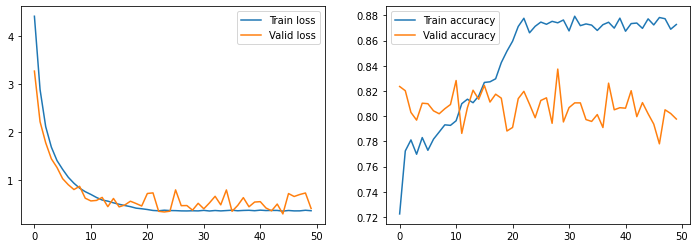

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()

plt.legend()
plt.show()

In [0]:
clf_model.save('/content/gdrive/My Drive/PS_50Epoch_degradingCONV.h5') 

In [0]:
clf_model.load_weights('/content/gdrive/My Drive/PS_50Epoch_degradingCONV.h5') 

In [0]:
from keras.models import Model
layer_outputs = [layer.output for layer in clf_model.layers]

def get_origin(x):
  edit = x.split('.')
  x1 = str(int(x.split('.')[7])-2)
  x2 = str(int(x.split('.')[-1])-1)

  edit[7] = x1
  edit[-1]= x2
  edit = '.'.join(edit)
  return edit


def get_img(x, positive = False):
  if positive:
    return pydicom.read_file(get_dcm(get_origin(x), train_dir)[0]).pixel_array
  else:
    return np.expand_dims(np.expand_dims(cv2.resize(pydicom.read_file(get_dcm(x, train_dir)[0]).pixel_array, (256,256)), 0), -1)

In [0]:
#Getting the infected with accuracy of 50% and above

Infected_list = []
for i in filenames:
  pred = clf_model.predict(get_img(i))

  if pred >= 0.5:
    Infected_list.append(i)

In [0]:
index=750
x=Infected_list[index]
img = get_img(x)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

In [0]:
activations[-1]

array([[0.6786041]], dtype=float32)

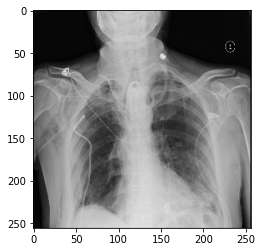

In [0]:
plt.imshow(np.reshape(img, (256,256)), cmap='gray');

In [0]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(10,10))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

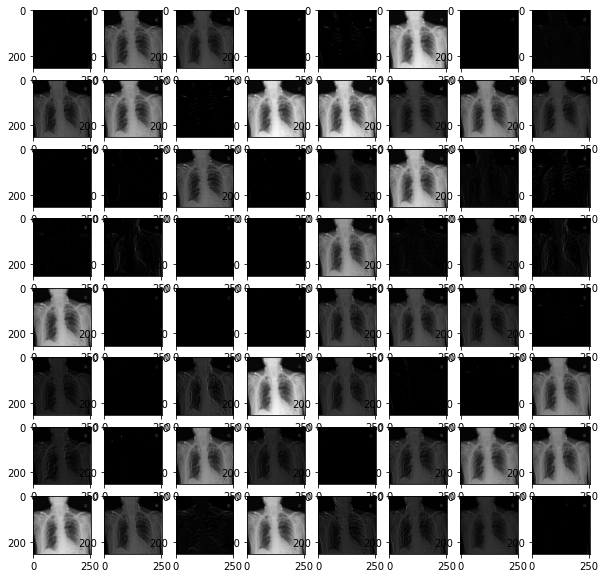

In [0]:
display_activation(activations, 8, 8, 0)

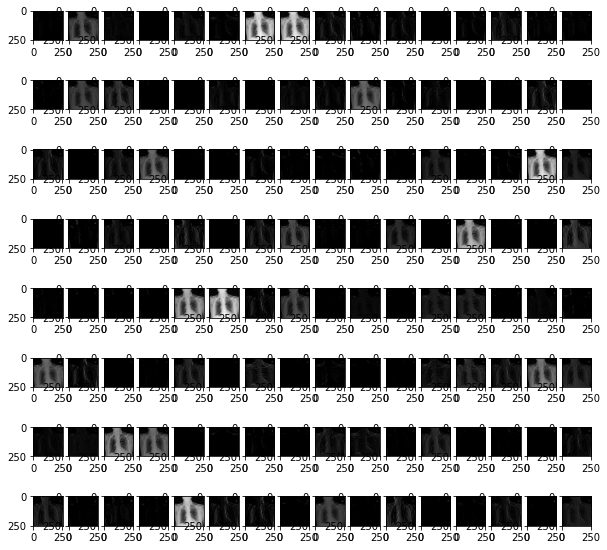

In [0]:
display_activation(activations, 16, 8, 1)

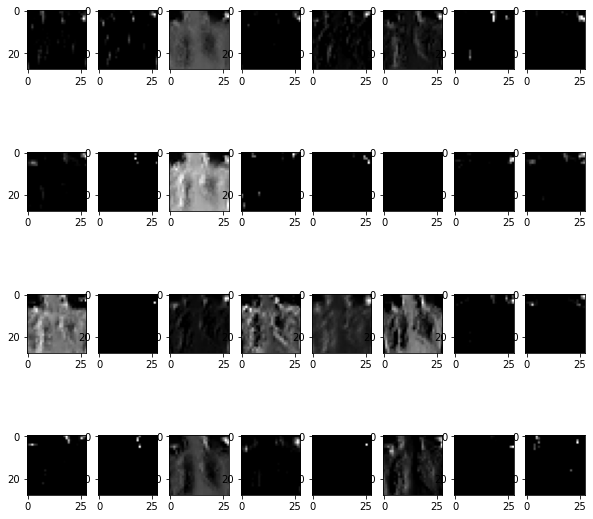

In [0]:
display_activation(activations, 8, 4, 7)

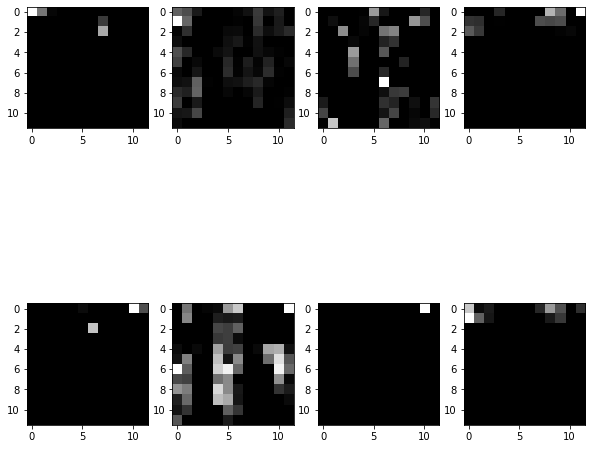

In [0]:
display_activation(activations, 4, 2, 9)

In [0]:
import keras as K
out = clf_model.output

last_conv_layer = clf_model.get_layer('conv2d_150')

grads = K.backend.gradients(out, last_conv_layer.output)[0]

pooled_grads = K.backend.mean(grads, axis=(0, 1, 2))

iterate = K.backend.function([clf_model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img])

for i in range(8):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

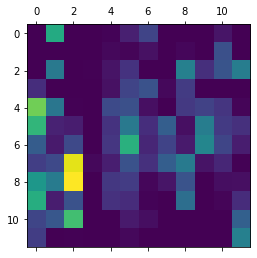

In [0]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [0]:
# We use cv2 to load the original image
img = get_img(x)[0,]
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))

heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('result.jpg', superimposed_img)

True

![alt text](https://drive.google.com/uc?id=1P4OdgR5hlMXyP33wR7zz8iopPAtNoLKN)

In [0]:
from mask_functions import rle2mask

But the heatmap of the classifier is different than the mask 

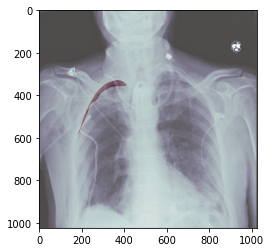

In [0]:
mask = rle2mask(df[df['ImageId'] == get_dcm(Infected_list[index], train_dir)[1]][' EncodedPixels'].values[0], 1024,1024).T

plt.imshow(cv2.resize(np.squeeze(np.squeeze(get_img(Infected_list[index]),0)-1), (1024,1024)), cmap=plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")

#Segmentation Part

In [0]:
from mask_functions import rle2mask

##Lets get the Infected list with propability of 30% so we can get some realistic.

In [0]:
Infected_list = []
for i in filenames:
  pred = model.predict(get_img(i))

  if pred >= 0.3:
    Infected_list.append(i)

In [0]:
len(Infected_list) # We have 2000 samples predicted positive

2871

##Check if images with no masks although predicted positive

In [0]:
Negative_Samples = df[df[' EncodedPixels'] == ' -1']

In [0]:
Negative_Samples.count()

ImageId           8296
 EncodedPixels    8296
dtype: int64

In [0]:
NS_list = Negative_Samples['ImageId'].values.astype(str)

In [0]:
NS_list[0:5]

array(['1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090',
       '1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137',
       '1.2.276.0.7230010.3.1.4.8323329.11364.1517875232.606684',
       '1.2.276.0.7230010.3.1.4.8323329.4541.1517875183.370160',
       '1.2.276.0.7230010.3.1.4.8323329.31759.1517875156.671103'],
      dtype='<U55')

##Check how many negative samples we have predicted from our model.

In [0]:
dcm_infected = [get_dcm(i, train_dir)[1] for i in Infected_list]

dcm_infected[0:5]

['1.2.276.0.7230010.3.1.4.8323329.2039.1517875170.835799',
 '1.2.276.0.7230010.3.1.4.8323329.1744.1517875169.213412',
 '1.2.276.0.7230010.3.1.4.8323329.11489.1517875233.189659',
 '1.2.276.0.7230010.3.1.4.8323329.10741.1517875225.413374',
 '1.2.276.0.7230010.3.1.4.8323329.300.1517875162.258081']

In [0]:
Negative_pred = [i for i in dcm_infected if i in NS_list]
Positive_pred = [i for i in dcm_infected if i not in NS_list]

In [0]:
print("We have {}/{} negative predictions, and we will test the segmentation on them ".format(len(Negative_pred), len(Infected_list)))

We have 1012/2871 negative predictions, and we will test the segmentation on them 


###Sample mask for positive predictions

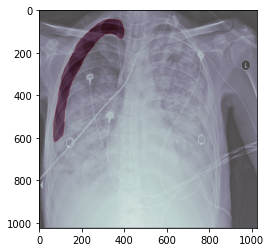

In [0]:
ID = np.random.randint(0, len(Positive_pred)-1)
img  = get_img(Positive_pred[ID], positive = True)
mask = rle2mask(df[df['ImageId'] == Positive_pred[ID]][' EncodedPixels'].values[0], 1024,1024).T

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")

##Lets define a generator to train on the fly and make a model

In [0]:
print("We have a data of size = ", len(Positive_pred))

We have a data of size =  1859


In [0]:
def generator_mask(filenames, TD, df, batch_size=32):

  while True:

    sample_fn = random.sample(filenames, batch_size)
    
    x_train = np.array([cv2.resize(pydicom.read_file(get_dcm(get_origin(patientId), TD)[0]).pixel_array, (256, 256)) for patientId in sample_fn if get_dcm(get_origin(patientId), TD)[1] in df['ImageId'].values])
    y_train = np.array([cv2.resize(rle2mask(df[df['ImageId'] == patientId][' EncodedPixels'].values[0], 1024, 1024).T/255, (256,256)) for patientId in sample_fn if get_dcm(get_origin(patientId), TD)[1] in df['ImageId'].values])
    
    
    yield  np.expand_dims(x_train, -1) , np.expand_dims(y_train, -1)
    #return np.squeeze(x_train, 0), np.squeeze(y_train,0)

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [23]:
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import Flatten
import keras.backend as K

inputs = Input((None, None, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

seg_model = Model(inputs=[inputs], outputs=[outputs])

seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 8 584         conv2d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, None, None, 8 0           conv2d_8[0][0]                   
____________________________________________________________________________________________

In [0]:
batch_size = 32
split = len(Positive_pred) // 10

Positive_valid_seg = Positive_pred[:split]
Positive_train_seg = Positive_pred[split:]

train_gen = generator_mask(Positive_train_seg, train_dir, df, batch_size)
valid_gen = generator_mask(Positive_valid_seg, train_dir, df, batch_size)

In [0]:
seg_model.compile(optimizer=keras.optimizers.adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = seg_model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    steps_per_epoch = int((len(Positive_train_seg)//batch_size)),
    validation_steps = int((len(Positive_valid_seg)//batch_size)),

)

Epoch 1/25
52/52 [==============================] - 43s 830ms/step - loss: 0.0769 - accuracy: 0.9881 - val_loss: 0.0458 - val_accuracy: 0.9904
Epoch 2/25
52/52 [==============================] - 38s 738ms/step - loss: 0.0544 - accuracy: 0.9884 - val_loss: 0.0353 - val_accuracy: 0.9903
Epoch 3/25
52/52 [==============================] - 38s 724ms/step - loss: 0.0523 - accuracy: 0.9887 - val_loss: 0.0608 - val_accuracy: 0.9898
Epoch 4/25
52/52 [==============================] - 36s 697ms/step - loss: 0.0473 - accuracy: 0.9890 - val_loss: 0.0411 - val_accuracy: 0.9898
Epoch 5/25
52/52 [==============================] - 36s 698ms/step - loss: 0.0460 - accuracy: 0.9890 - val_loss: 0.0494 - val_accuracy: 0.9894
Epoch 6/25
52/52 [==============================] - 38s 725ms/step - loss: 0.0444 - accuracy: 0.9889 - val_loss: 0.0595 - val_accuracy: 0.9889
Epoch 7/25
52/52 [==============================] - 38s 740ms/step - loss: 0.0434 - accuracy: 0.9886 - val_loss: 0.0400 - val_accuracy: 0.9903

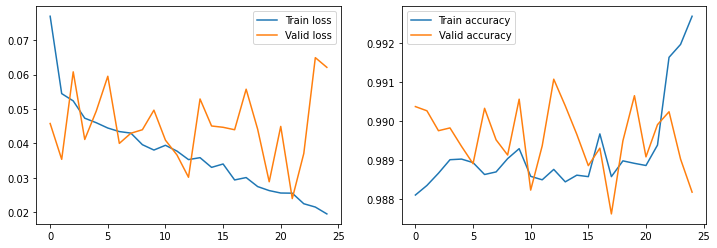

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()

plt.legend()
plt.show()

In [0]:
seg_model.save('/content/gdrive/My Drive/PS_SegmenUnet25BC.h5') 

##Creating masks for Negative predictions but classified as infected

Text(0.5, 1.0, 'Predicting mask for X-ray classified as negative')

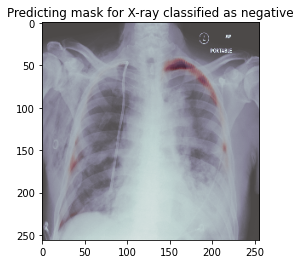

In [0]:
#let's try to predict a mask for the negative sample
seg_model.load_weights('/content/gdrive/My Drive/PS_SegmenUnet25BC.h5') 
ID = np.random.randint(0, len(Negative_pred)-1)
img  = cv2.resize(get_img(Negative_pred[ID], positive = True) , (256,256))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = model.predict(img_for_pred)*255
mask = np.squeeze(np.squeeze(mask, -1),0)

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title("Predicting mask for X-ray classified as negative")

##Validating Positive predictions that are classified as infected and actual masks

Text(0.5, 1.0, 'Predicting Mask for x-ray classified positive')

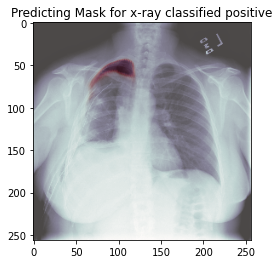

In [0]:
#let's see out model prediction and actual real masks

ID = np.random.randint(0, len(Positive_pred)-1)
img  = cv2.resize(get_img(Positive_pred[ID], positive = True) , (256,256))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = model.predict(img_for_pred)*255
mask = np.squeeze(np.squeeze(mask, -1),0)

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title('Predicting Mask for x-ray classified positive')

Text(0.5, 1.0, 'Real mask for classified as positive')

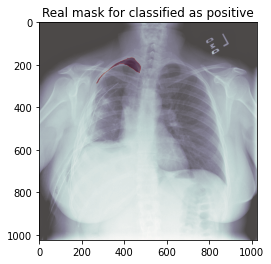

In [0]:
img  = cv2.resize(get_img(Positive_pred[ID], positive = True) , (1024,1024))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = rle2mask(df[df['ImageId'] == Positive_pred[ID]][' EncodedPixels'].values[0], 1024,1024).T

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title("Real mask for classified as positive")

##let's try 25 more epochs

In [0]:
seg_model.load_weights('/content/gdrive/My Drive/PS_SegmenUnet25BC.h5') 
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=25,
    steps_per_epoch = int((len(Positive_train_seg)//batch_size)),
    validation_steps = int((len(Positive_valid_seg)//batch_size)),

)

Epoch 1/25
52/52 [==============================] - 41s 787ms/step - loss: 0.0205 - accuracy: 0.9922 - val_loss: 0.0374 - val_accuracy: 0.9889
Epoch 2/25
52/52 [==============================] - 37s 719ms/step - loss: 0.0191 - accuracy: 0.9929 - val_loss: 0.0277 - val_accuracy: 0.9884
Epoch 3/25
52/52 [==============================] - 37s 711ms/step - loss: 0.0187 - accuracy: 0.9928 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 4/25
52/52 [==============================] - 37s 713ms/step - loss: 0.0171 - accuracy: 0.9935 - val_loss: 0.0406 - val_accuracy: 0.9904
Epoch 5/25
52/52 [==============================] - 37s 719ms/step - loss: 0.0168 - accuracy: 0.9936 - val_loss: 0.0574 - val_accuracy: 0.9903
Epoch 6/25
52/52 [==============================] - 37s 721ms/step - loss: 0.0164 - accuracy: 0.9938 - val_loss: 0.0568 - val_accuracy: 0.9882
Epoch 7/25
52/52 [==============================] - 37s 720ms/step - loss: 0.0157 - accuracy: 0.9940 - val_loss: 0.0261 - val_accuracy: 0.9896

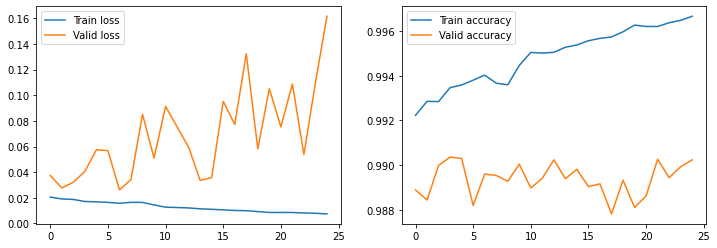

In [0]:
seg_model.save('/content/gdrive/My Drive/PS_SegmenUnet25BCadd25.h5') 

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()

plt.legend()
plt.show()

Text(0.5, 1.0, 'Predicting mask for x-ray classified negative (after 50 epoch)')

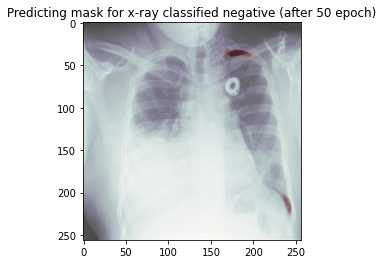

In [0]:
seg_model.load_weights('/content/gdrive/My Drive/PS_SegmenUnet25BCadd25.h5') 
#let's try to predict a mask for the negative sample

ID = np.random.randint(0, len(Negative_pred)-1)
img  = cv2.resize(get_img(Negative_pred[ID], positive = True) , (256,256))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = model.predict(img_for_pred)*255
mask = np.squeeze(np.squeeze(mask, -1),0)

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title("Predicting mask for x-ray classified negative (after 50 epoch)")

Text(0.5, 1.0, 'Predicting mask for x-ray classified positive (after 50 epoch)')

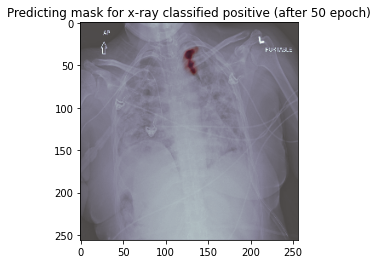

In [0]:
#let's see out model prediction and actual real masks

ID = np.random.randint(0, len(Positive_pred)-1)
img  = cv2.resize(get_img(Positive_pred[ID], positive = True) , (256,256))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = model.predict(img_for_pred)*255
mask = np.squeeze(np.squeeze(mask, -1),0)

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title("Predicting mask for x-ray classified positive (after 50 epoch)")

Text(0.5, 1.0, 'Real mask for x-ray classified positive (after 50 epoch)')

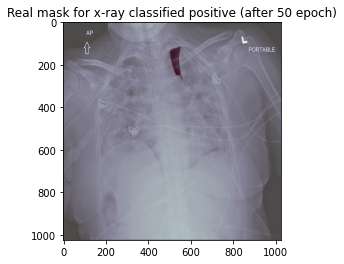

In [0]:
img  = cv2.resize(get_img(Positive_pred[ID], positive = True) , (1024,1024))
img_for_pred = np.expand_dims(np.expand_dims(img, 0),-1)

mask = rle2mask(df[df['ImageId'] == Positive_pred[ID]][' EncodedPixels'].values[0], 1024,1024).T

plt.imshow(img , cmap = plt.cm.bone)
plt.imshow(mask , alpha=0.3, cmap="Reds")
plt.title("Real mask for x-ray classified positive (after 50 epoch)")

In [0]:
seg_model.load_weights('/content/gdrive/My Drive/PS_SegmenUnet25BCadd25.h5') 

#Let's compare the whole pipline with the actual positive and actual negative that are in the original dataset

In [25]:
df.head()

ImageId                                      EncodedPixels
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...                                                 -1
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...                                                 -1
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

In [0]:
Original_pos = df[df[" EncodedPixels"] != ' -1']['ImageId'].values
Original_neg = df[df[" EncodedPixels"] == ' -1']['ImageId'].values

In [0]:
def create_random_data(filenames, TD, df, batch_size=10, has_mask= True ):
  
  sample_fn = random.sample(filenames, batch_size)
    
  x_train = np.array([cv2.resize(pydicom.read_file(get_dcm(get_origin(patientId), TD)[0]).pixel_array, (256, 256)) for patientId in sample_fn if get_dcm(get_origin(patientId), TD)[1] in df['ImageId'].values])
  if has_mask:
    y_train = np.array([cv2.resize(rle2mask(df[df['ImageId'] == patientId][' EncodedPixels'].values[0], 1024, 1024).T/255, (256,256)) for patientId in sample_fn if get_dcm(get_origin(patientId), TD)[1] in df['ImageId'].values])
  else: y_train = np.array([0])
    
  return np.expand_dims(x_train, -1) , np.expand_dims(y_train, -1)

In [0]:
Positive_imgs, Positive_masks  = create_random_data(list(Original_pos), train_dir, df, 10)

Negative_imgs, _  = create_random_data(list(Original_neg), train_dir, df, 10, has_mask = False)

In [0]:
def remove_dims(x):
  return np.squeeze(x,-1)

In [66]:
print('Positive images shape = ',Positive_imgs.shape)
print('Positive masks shape = ',Positive_masks.shape)
print('Negative images shape = ',Negative_imgs.shape)

Positive images shape =  (10, 256, 256, 1)
Positive masks shape =  (10, 256, 256, 1)
Negative images shape =  (10, 256, 256, 1)


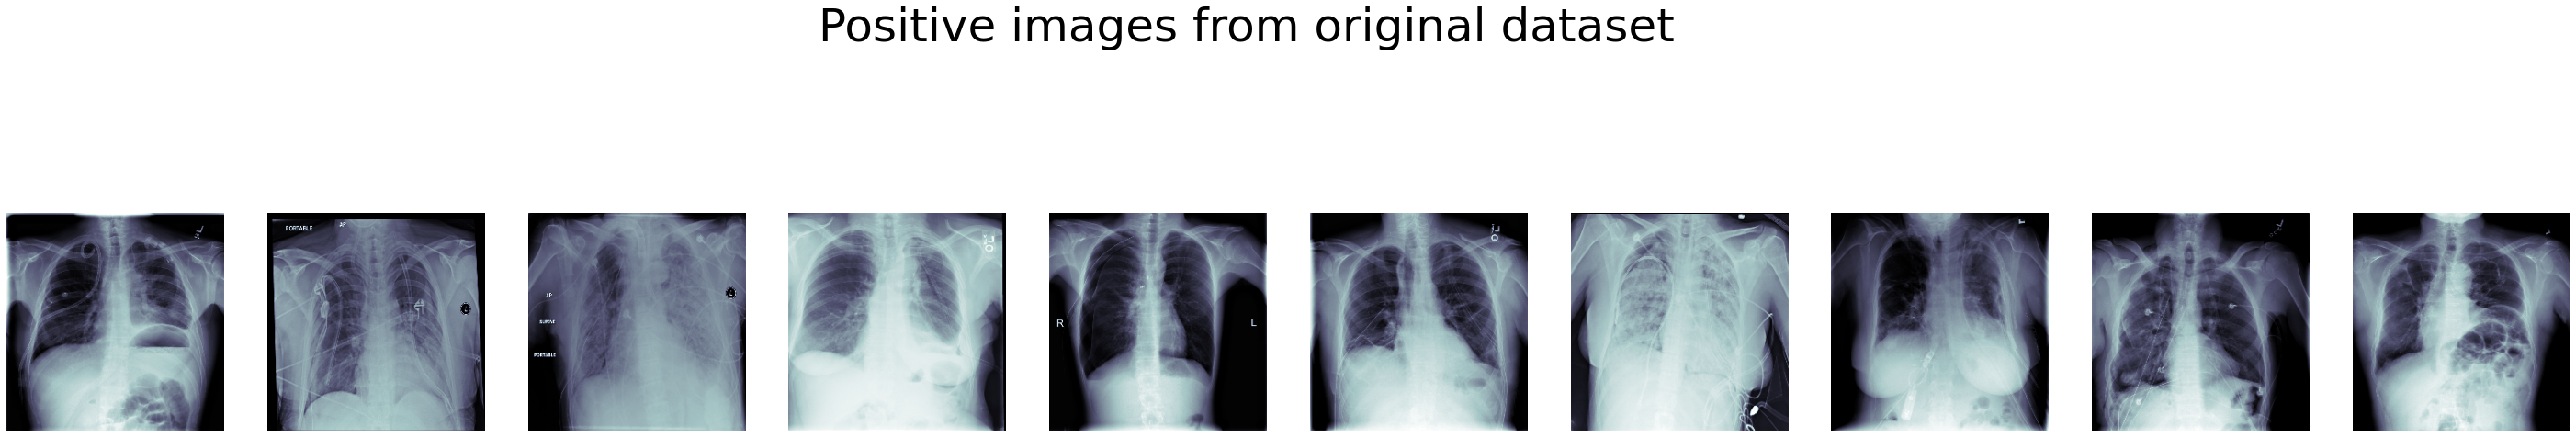

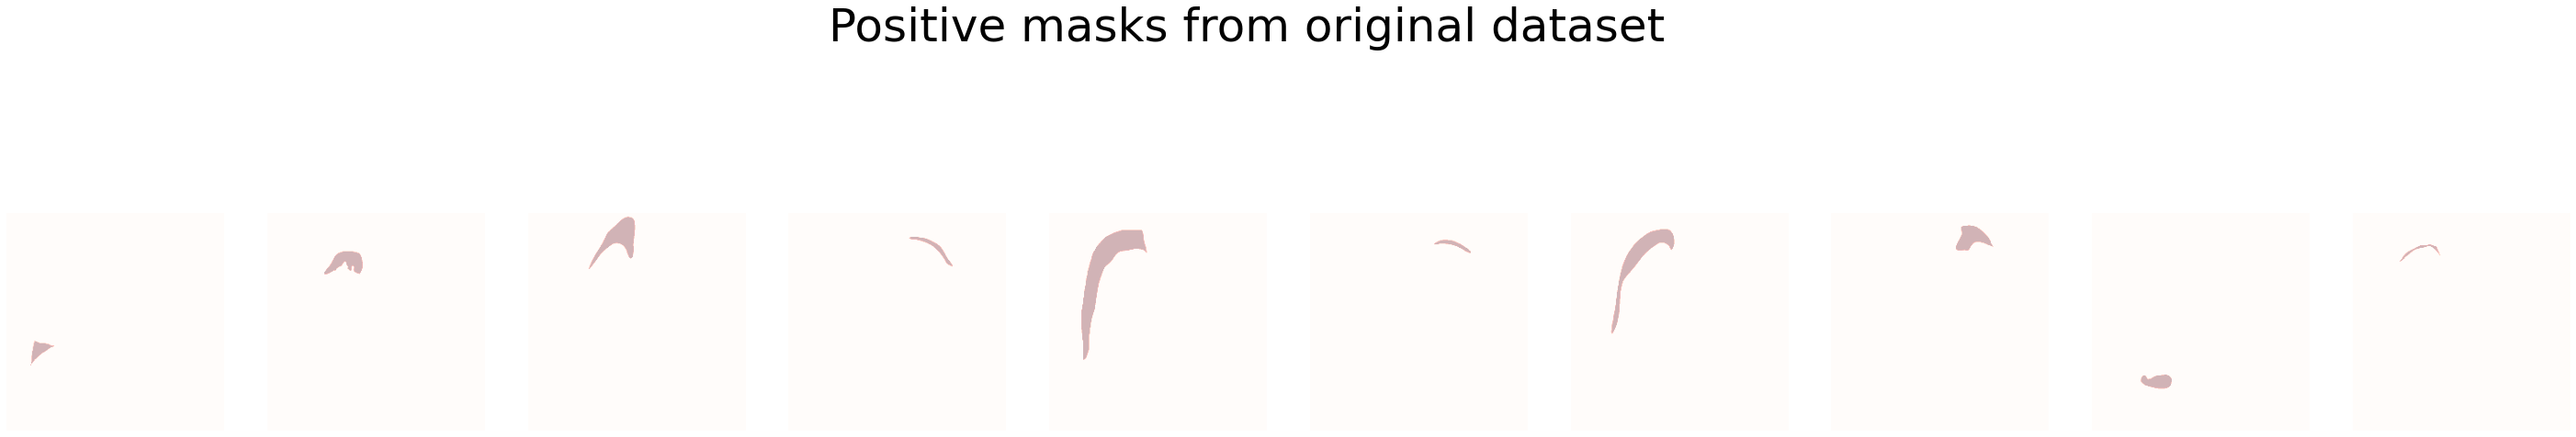

In [159]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Positive images from original dataset", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Positive_imgs[j,:,:]), cmap = plt.cm.bone)
  axs[j].axis('off')

fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Positive masks from original dataset", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Positive_masks[j,:,:]),alpha=0.3, cmap="Reds")
  axs[j].axis('off')

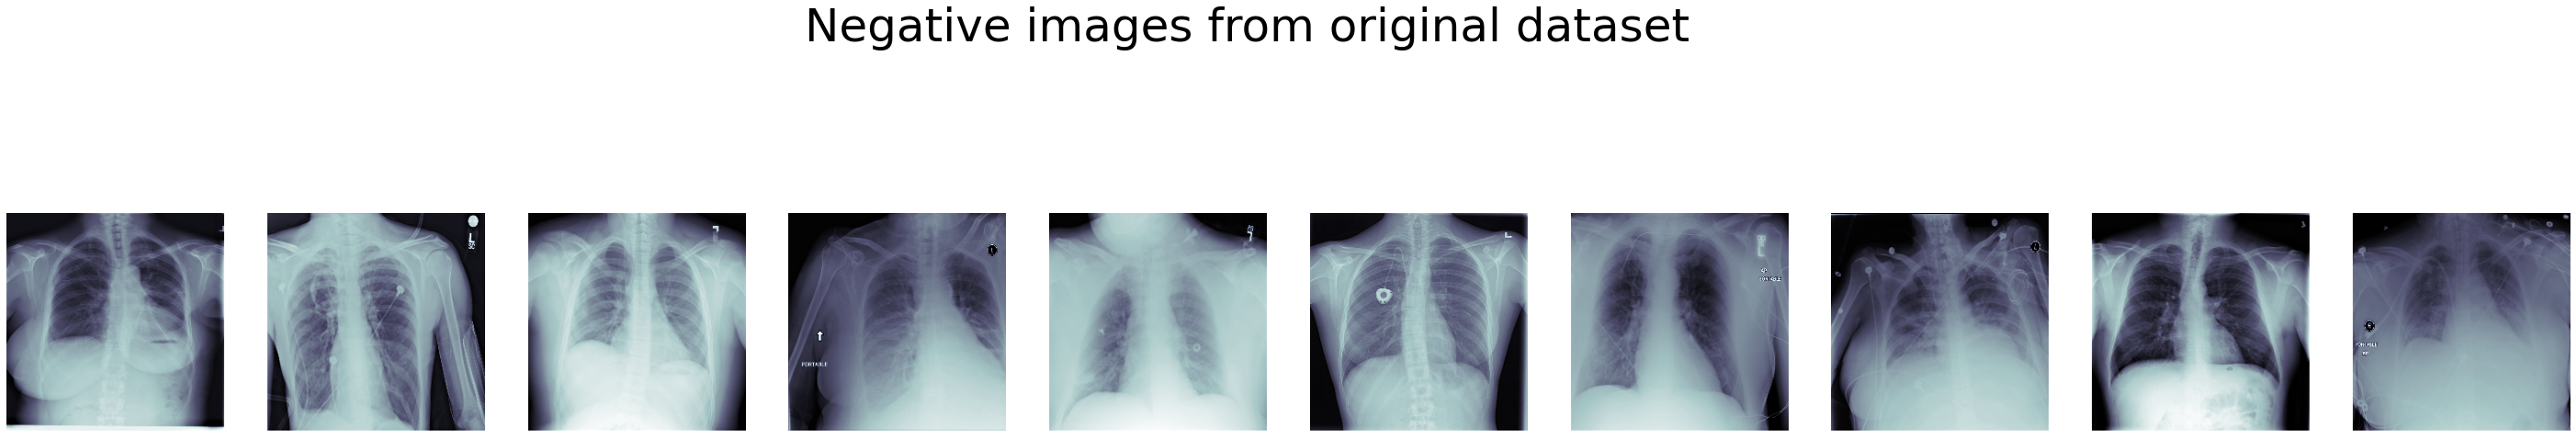

In [158]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Negative images from original dataset", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Negative_imgs[j,:,:]), cmap= plt.cm.bone)
  axs[j].axis('off')

#Now we will classify each of them

In [0]:
clf_Positive_imgs = clf_model.predict(Positive_imgs)
clf_Negative_imgs = clf_model.predict(Negative_imgs)

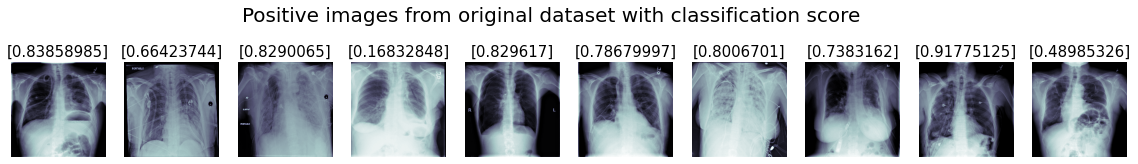

In [153]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (20,3))
fig.suptitle("Positive images from original dataset with classification score", fontsize=20)

for j in range (10):
  axs[j].imshow(remove_dims(Positive_imgs[j,:,:]), cmap = plt.cm.bone)
  axs[j].axis('off')
  axs[j].set_title(str(clf_Positive_imgs[j]), fontdict={'fontsize':15})

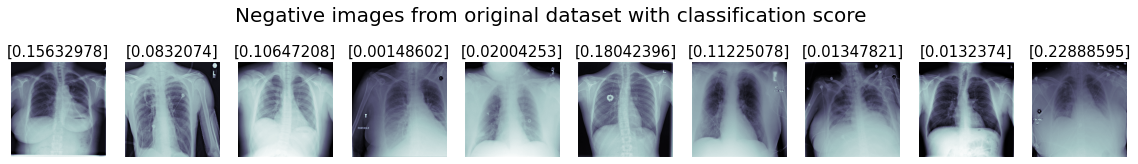

In [152]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (20,3))
fig.suptitle("Negative images from original dataset with classification score", fontsize=20)

for j in range (10):
  axs[j].imshow(remove_dims(Negative_imgs[j,:,:]), cmap = plt.cm.bone)
  axs[j].axis('off')
  axs[j].set_title(str(clf_Negative_imgs[j]), fontdict={'fontsize':15})

##Let's do the segmentation part

In [0]:
seg_Positive_imgs = remove_dims(seg_model.predict(Positive_imgs))
seg_Negative_imgs = remove_dims(seg_model.predict(Negative_imgs))

In [140]:
seg_Positive_imgs.shape

(10, 256, 256)

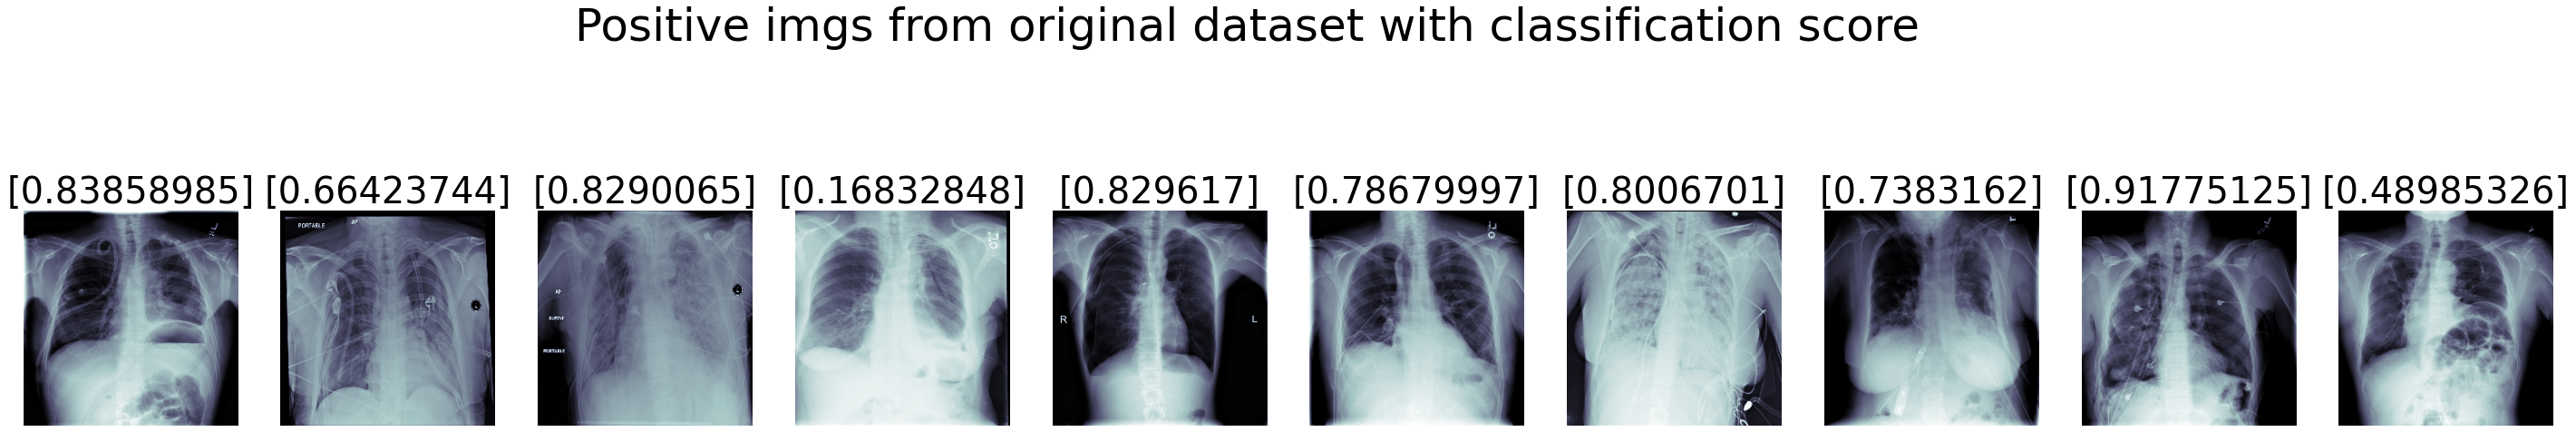

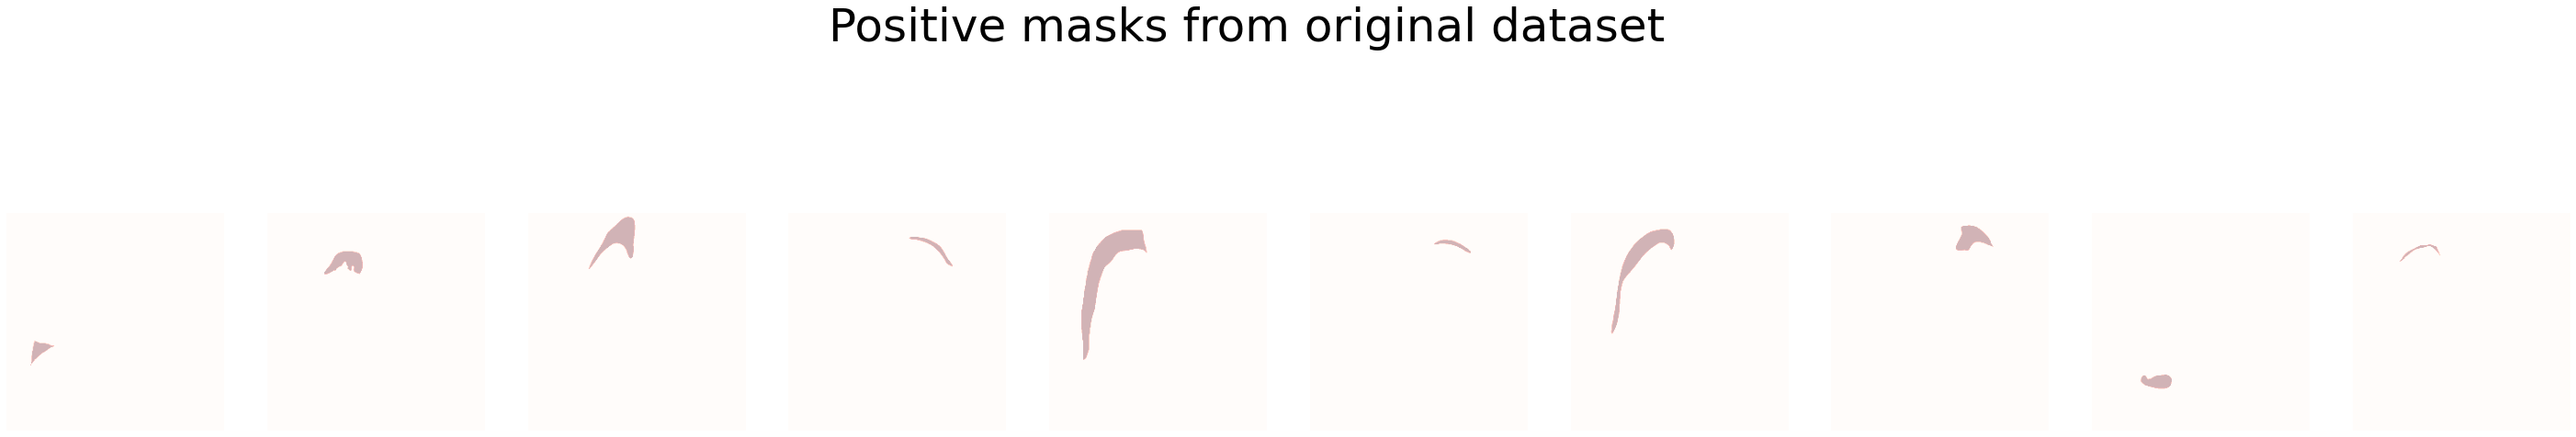

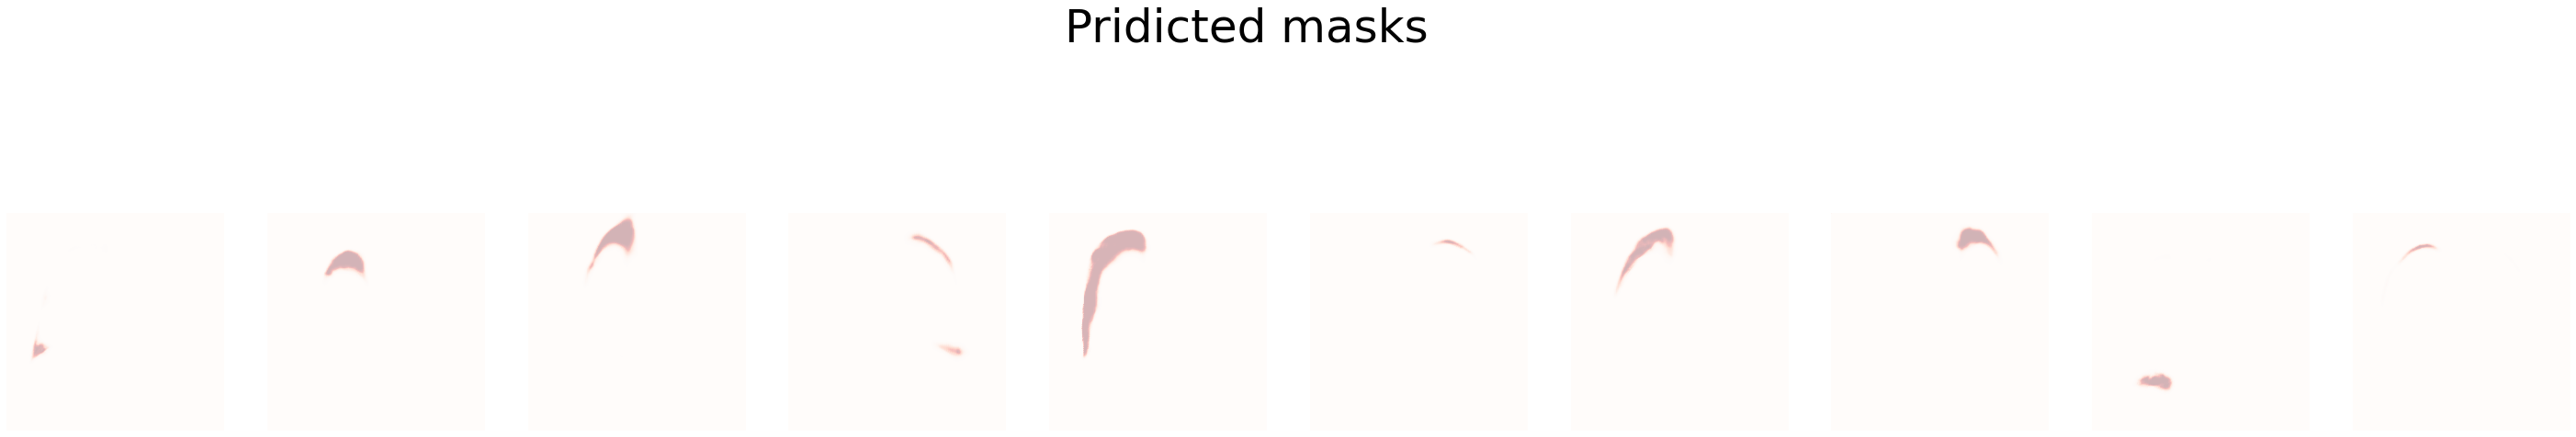

In [154]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Positive imgs from original dataset with classification score", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Positive_imgs[j,:,:]), cmap = plt.cm.bone)
  axs[j].axis('off')
  axs[j].set_title(str(clf_Positive_imgs[j]), fontdict={'fontsize':40})

fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Positive masks from original dataset", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Positive_masks[j,:,:]),alpha=0.3, cmap="Reds")
  axs[j].axis('off')

fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Pridicted masks", fontsize=50)
for j in range (10):
  axs[j].imshow(seg_Positive_imgs[j,:,:],alpha=0.3, cmap="Reds")
  axs[j].axis('off')

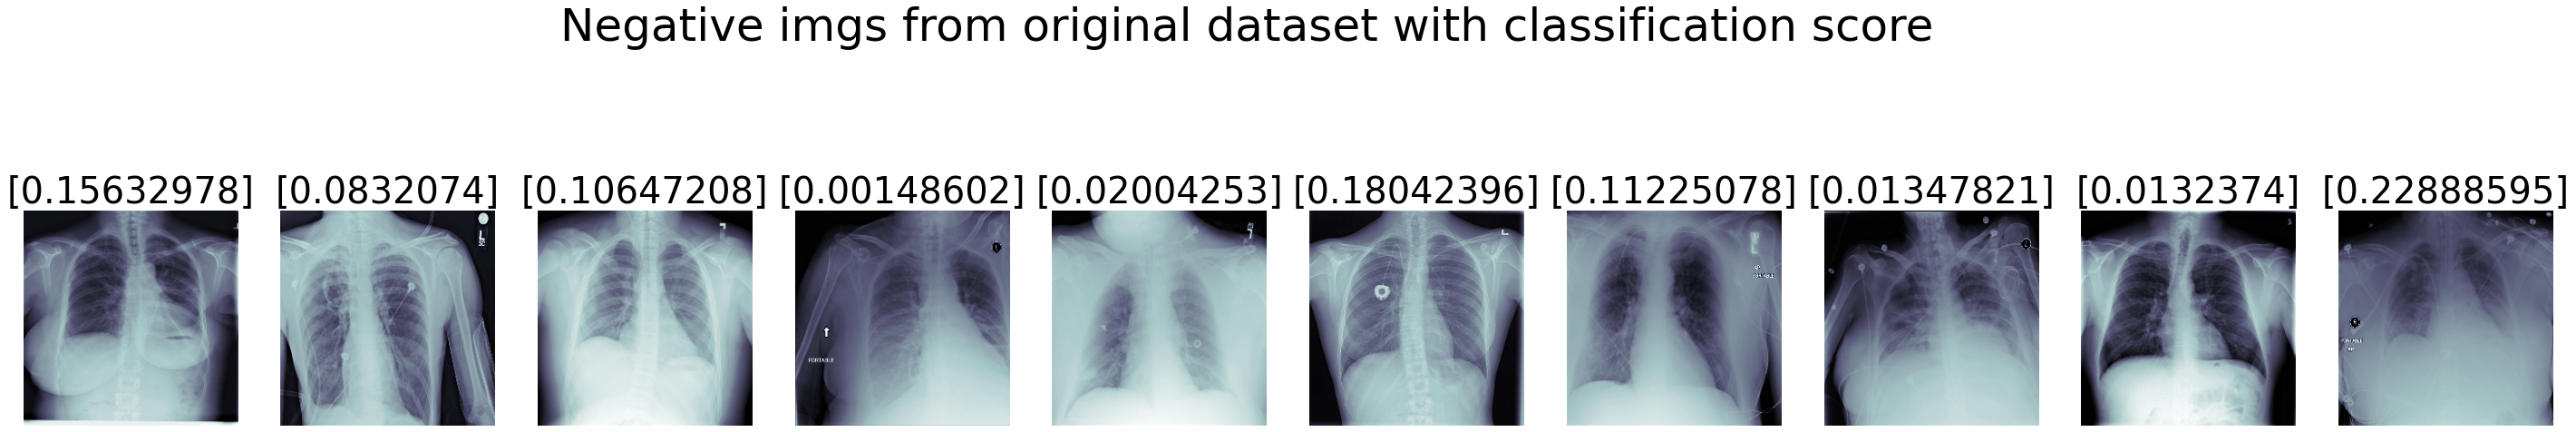

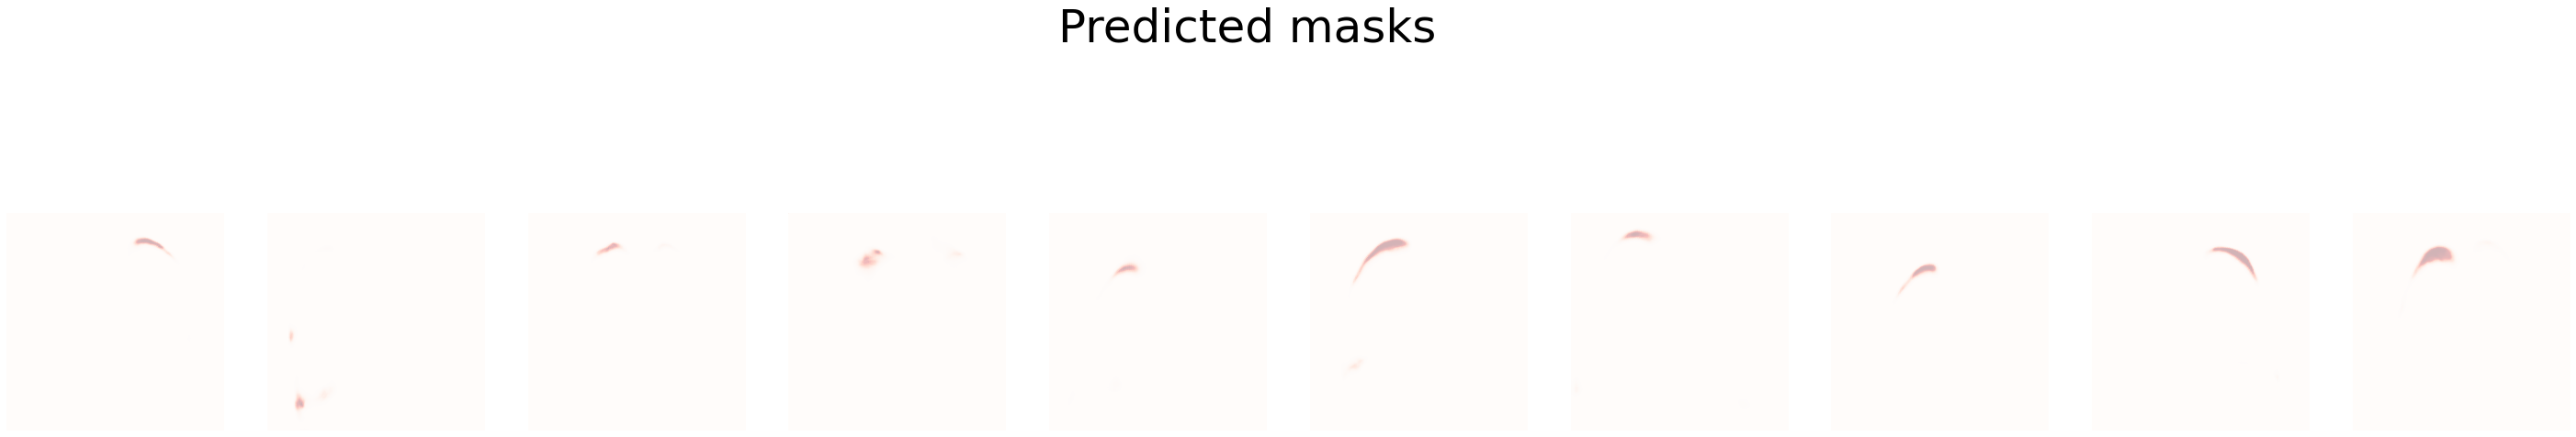

In [155]:
fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Negative imgs from original dataset with classification score", fontsize=50)
for j in range (10):
  axs[j].imshow(remove_dims(Negative_imgs[j,:,:]), cmap = plt.cm.bone)
  axs[j].axis('off')
  axs[j].set_title(str(clf_Negative_imgs[j]), fontdict={'fontsize':40})

fig, axs = plt.subplots(1, 10, sharey=True, figsize = (50,10))
fig.suptitle("Predicted masks", fontsize=50)
for j in range (10):
  axs[j].imshow(seg_Negative_imgs[j,:,:],alpha=0.3, cmap="Reds")
  axs[j].axis('off')